# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.icat import icat as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [22]:
limits = dict(g_CaT=(0, 2),
              v_offset=(0, 500),
              p1=(0, 100),
              p2=(0, 10),
              p3=(0, 10),
              p4=(0, 10),
              p5=(0, 0.5),
              p6=(0, 500),
              q1=(0, 100),
              q2=(0, 50),
              q3=(0, 50),
              q4=(0, 500),
              q5=(0, 0.5),
              q6=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Parameter sensitivity analysis

In [10]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

In [11]:
parameters = ['icat.'+k for k in limits.keys()]

In [12]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000)

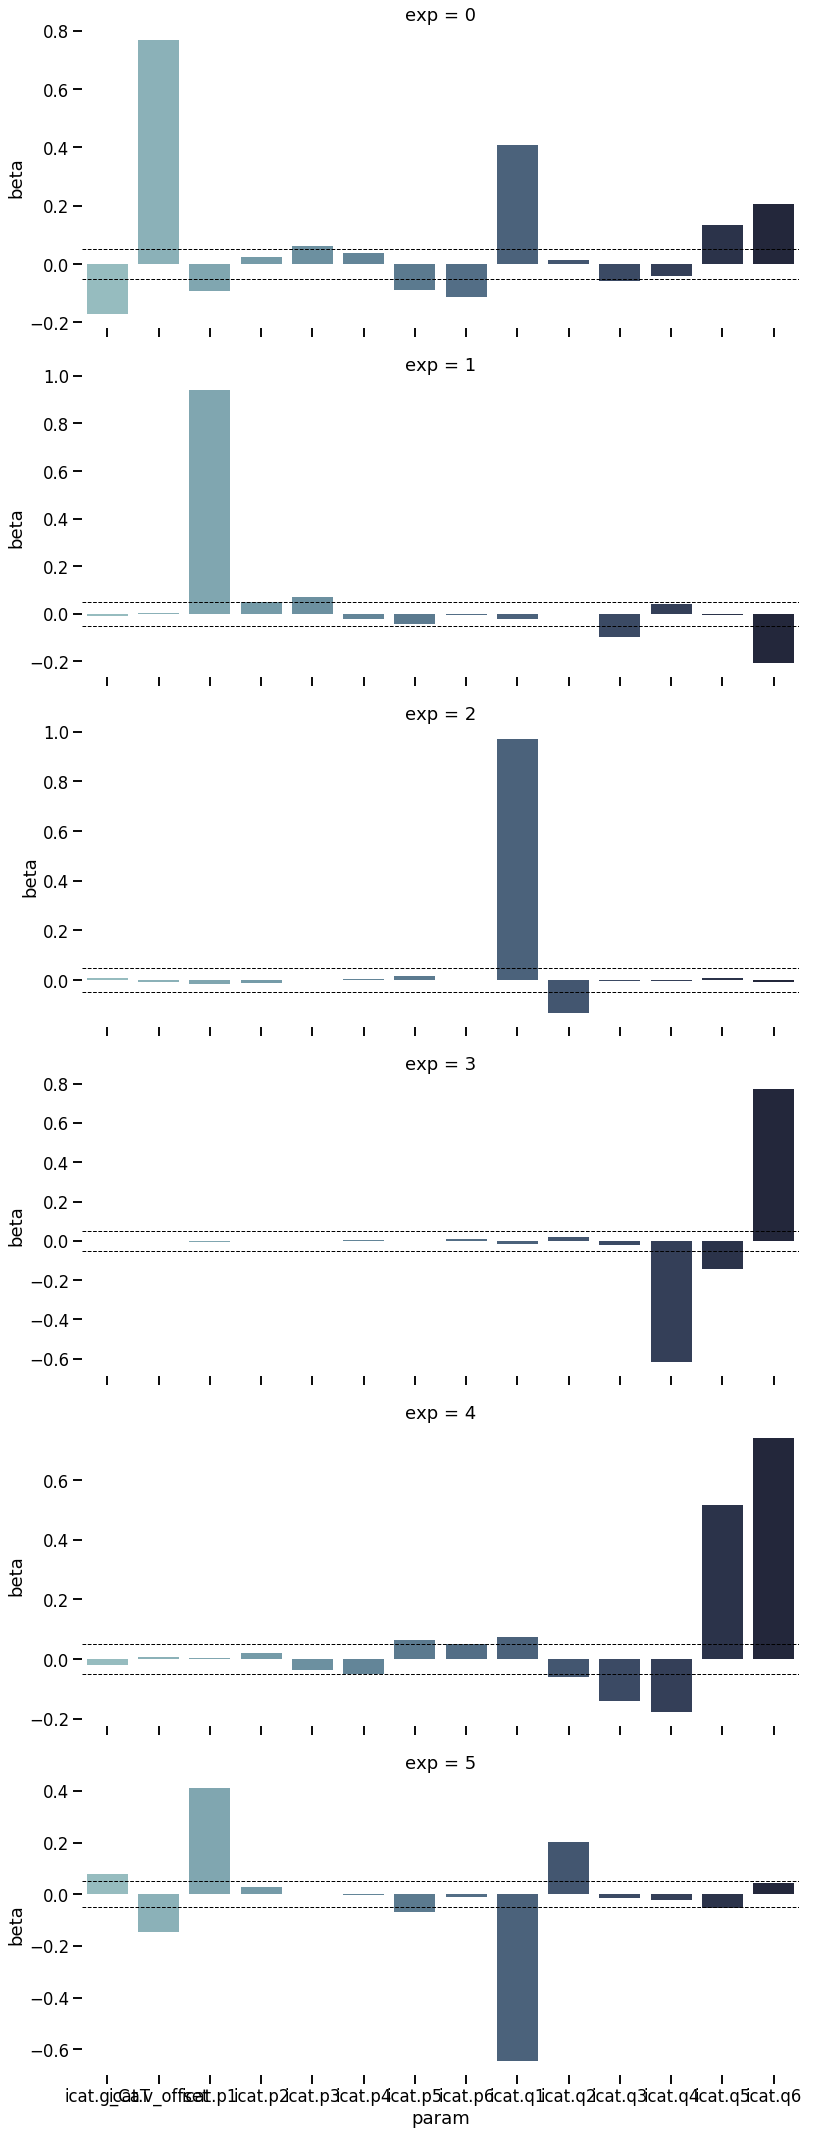

In [13]:
sns.set_context('talk')
grid = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

In [14]:
grid.savefig('results/icat/sensitivity.pdf')

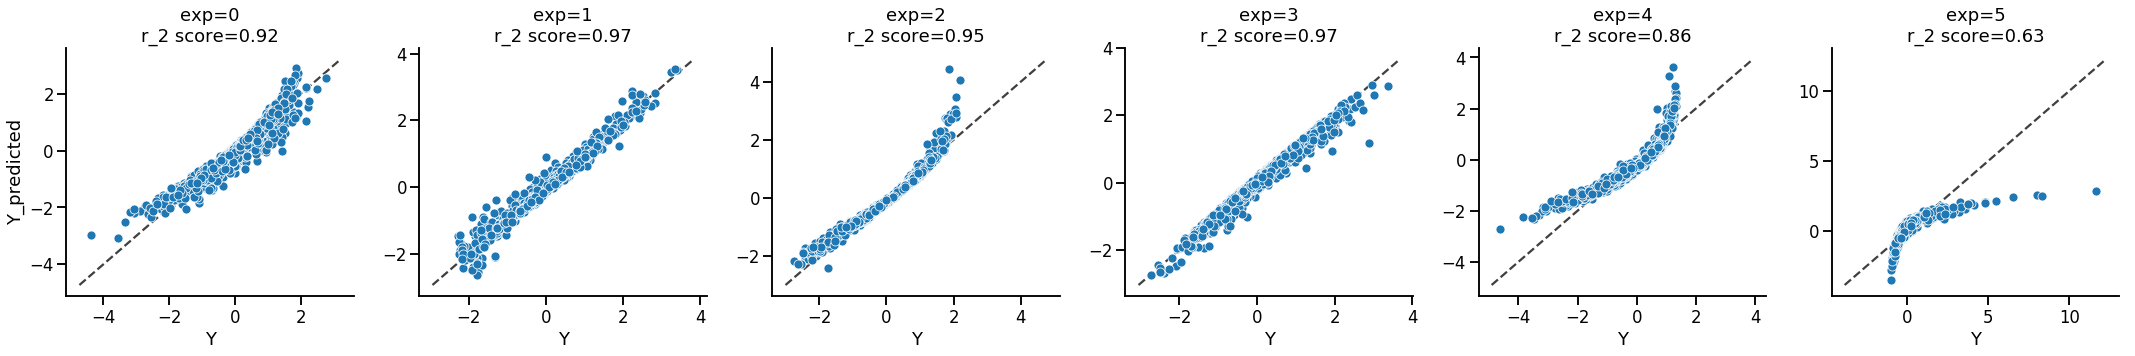

In [15]:
grid2 = plot_regression_fit(regression_fit, r2)

In [16]:
grid2.savefig('results/icat/sensitivity_fit.pdf')

# Weights of distance function

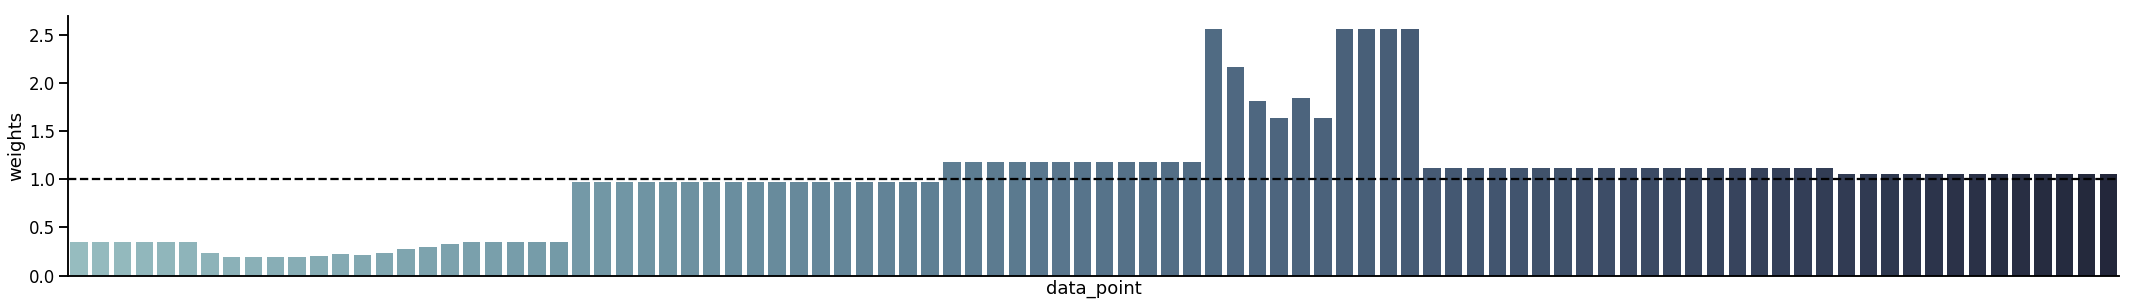

In [17]:
from ionchannelABC import plot_distance_weights
grid = plot_distance_weights(model, distance_fn)

In [18]:
grid.savefig('results/icat/dist_weights.pdf')

# Initialize pyabc database

In [47]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat1000.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_icat1000.db


In [48]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [49]:
from pyabc.populationstrategy import ConstantPopulationSize

In [50]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(1000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=5000,
             #    mean_cv=0.2,
             #    max_population_size=5000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.3437158292831627, 1: 0.3437158292831627, 2: 0.3437158292831627, 3: 0.3437158292831627, 4: 0.3437158292831627, 5: 0.3437158292831627, 6: 0.23359946175355675, 7: 0.19709954585456368, 8: 0.19709954585456368, 9: 0.19709954585456368, 10: 0.19406724514910909, 11: 0.20345759572083993, 12: 0.22525662383378656, 13: 0.21023951557820128, 14: 0.23800699876777479, 15: 0.27422545510200186, 16: 0.30034216511171646, 17: 0.32344540858184795, 18: 0.3437158292831627, 19: 0.3437158292831627, 20: 0.3437158292831627, 21: 0.3437158292831627, 22: 0.3437158292831627, 23: 0.9694434159168854, 24: 0.9694434159168854, 25: 0.9694434159168854, 26: 0.9694434159168854, 27: 0.9694434159168854, 28: 0.9694434159168854, 29: 0.9694434159168854, 30: 0.9694434159168854, 31: 0.9694434159168854, 32: 0.9694434159168854, 33: 0.9694434159168854, 34: 0.9694434159168854, 35: 0.9694434159168854, 36: 0.9694434159168854, 37: 0.9694434159168854, 38: 0.9694434159168854, 39: 0.9694434159168854, 40: 1.

In [51]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-11-15 08:34:59.968297, end_time=None)>
INFO:Epsilon:initial epsilon is 112.56219831919914


In [52]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:112.56219831919914
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2202
DEBUG:Epsilon:new eps, t=1, eps=38.95422003274088
INFO:ABC:t:1 eps:38.95422003274088
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 4516
DEBUG:Epsilon:new eps, t=2, eps=19.408353122593144
INFO:ABC:t:2 eps:19.408353122593144
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 7518
DEBUG:Epsilon:new eps, t=3, eps=11.67155877338393
INFO:ABC:t:3 eps:11.67155877338393
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 11042
DEBUG:Epsilon:new eps, t=4, eps=9.331090207860234
INFO:ABC:t:4 eps:9.331090207860234
DEBUG:ABC:now submitting population 4
Process Process-4910:
Process Process-4919:
Process Process-4911:
Process Process-4914:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.2-py3.6.egg/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.2-py3.6.egg/pyabc/smc.py", line 660, in simulate_one
    par = self._generate_valid_proposal(t, m, p)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.2-py3.6.egg/pyabc/smc.py", line 496, in _generate_valid_proposal
    * self.parameter_priors[m_ss].pdf(theta_ss) > 0):
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.

  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.2-py3.6.egg/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.2-py3.6.egg/pyabc/transition/multivariatenormal.py", line 76, in rvs_single
    np.zeros(self.cov.shape[0]), self.cov))
  File "mtrand.pyx", line 4527, in mtrand.RandomState.multivariate_normal
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/numpy/core/numeric.py", line 2270, in allclose
    res = all(isclose(a, b, rtol=rtol, atol=atol, equal_nan=equal_nan))
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/numpy/core/numeric.py", line 2365, in isclose
    if all(xfin) and all(yfin):
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 2089, in all
    return _wrapreduction(a, np.logical_an

# Results analysis

In [56]:
history = [History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat/hl-1_icat50.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat/hl-1_icat100.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat/hl-1_icat500.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat/hl-1_icat750.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat/hl-1_icat1000.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat/hl-1_icat1250.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat/hl-1_icat2000.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat/hl-1_icat5000.db')]
particle_num = [50,100,500,750,1000,1250,2000,5000]

In [57]:
df, w = history[1].get_distribution(m=0)

In [58]:
n_samples=5000
th_samples = pd.DataFrame({})
for h, p in zip(history, particle_num):
    df, w = h.get_distribution(m=0)
    th = pd.DataFrame(df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records'))
    th['particle_num'] = p
    th_samples = th_samples.append(th)

In [59]:
th_samples = th_samples.melt(value_vars=['g_CaT','p1','p2','p3','p4','p5','p6','q1','q2','q3','q4','q5','q6','v_offset'], id_vars=['particle_num'])

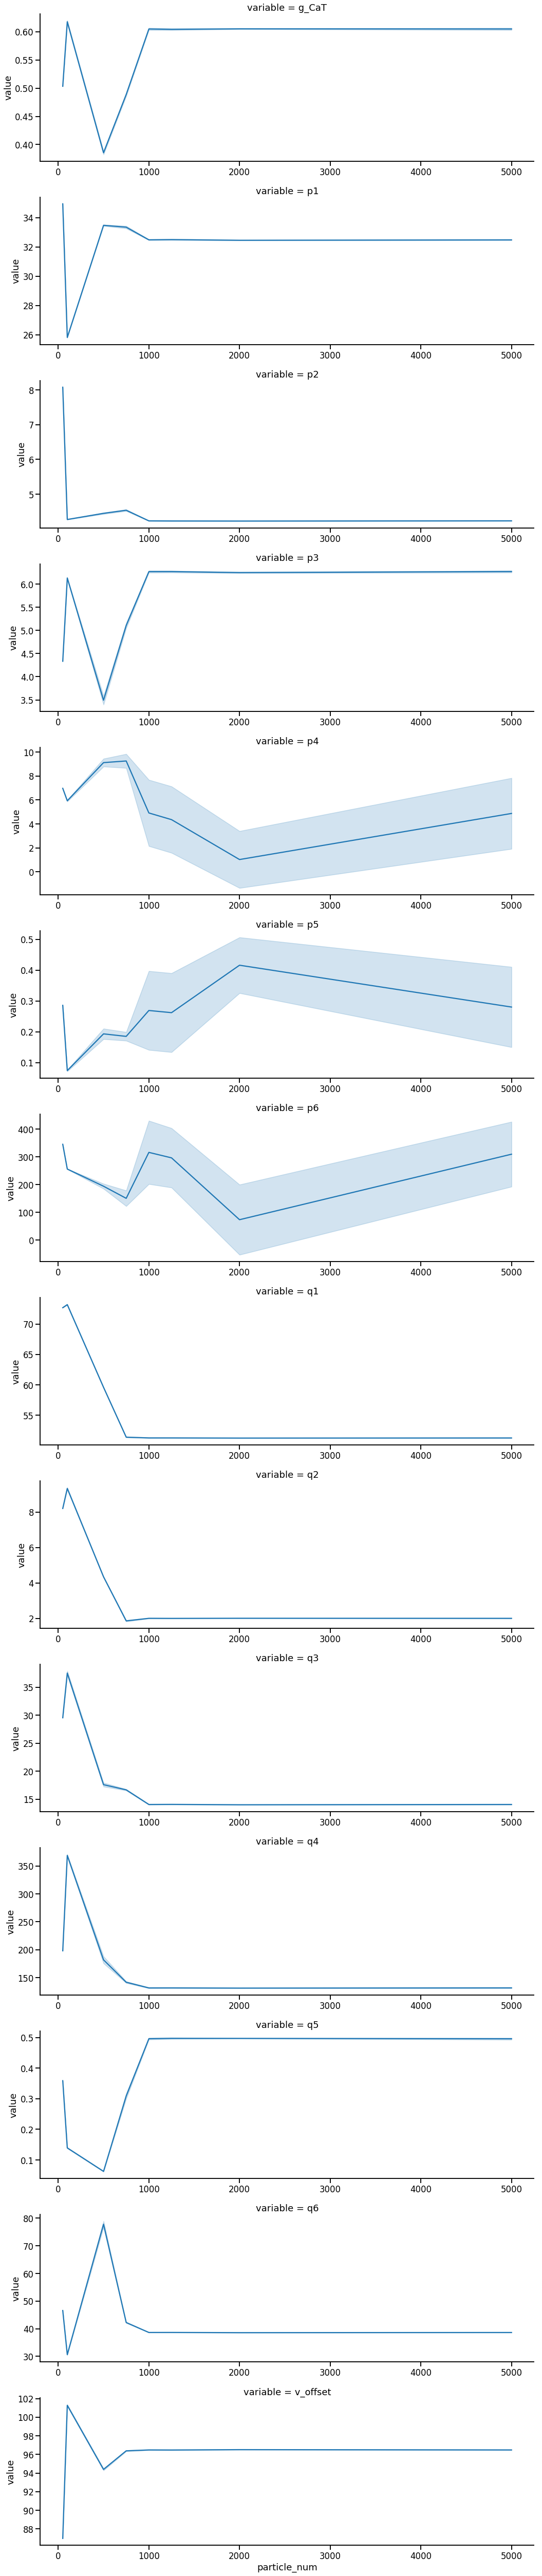

In [61]:
sns.set_context('talk')
grid = sns.relplot(x='particle_num',y='value',row='variable',data=th_samples,
                   kind='line',n_boot=5000,ci='sd',aspect=3,
                   facet_kws={'sharex': 'row',
                   'sharey': False})

In [62]:
grid.savefig('results/convergence/icat/icat_convergence.pdf')